# Residual Modell
Nachdem wir eine Basis-Architektur erstellt und auch ein Transfer-Learning versucht haben, wurde eine neuere und grössere Architektur erstellt. Diese beinhaltet mehr Schichten und somit auch mehr Parameter. Zusätzlich wird noch mit Residuen gearbeitet, welche bei anderen Modellarchitekturen bereits vielversprechende Ergebnisse gezeigt haben.

Das Laden der Daten und der Training-Loop sind dabei sehr ähnlich zum Basis-Skript.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from matplotlib import pyplot as plt

# Recommended to leave default values
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Customizable values
BATCH_SIZE = 64

In [2]:
_data_dir = os.path.join("data", "dog_bird", "images")
_entries = os.listdir(_data_dir)
_folder_count = sum(os.path.isdir(os.path.join(_data_dir, entry)) for entry in _entries)

TRAIN_DS, VAL_DS = keras.utils.image_dataset_from_directory(
    _data_dir,
    labels="inferred",
    label_mode="binary" if _folder_count == 2 else "categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    interpolation="bilinear",
    pad_to_aspect_ratio=True,
    validation_split=0.2,
    subset="both",
    seed=42,
)


if len(TRAIN_DS.class_names) == 2:
    NUMBER_OF_CLASSES = 1
else:
    NUMBER_OF_CLASSES = len(TRAIN_DS.class_names)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Using 4000 files for validation.


Das Modell orientiert sich am Aufbau der Basis-Architektur und übernimmt einige Schichten. Insgesamt beinhaltet es aber mehr Schichten und zusätzlich Residuen.

In [3]:
def make_model():
    # Input and augmentation
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = layers.RandomContrast(0.4)(inputs)
    x = layers.RandomBrightness(0.4)(x)
    x = layers.Rescaling(1.0 / 255)(x)
    
    # First Layers for residual connection
    x = layers.Conv2D(8, kernel_size=(3,3), activation="relu")(x)
    x = layers.BatchNormalization()(x)
    previous_activation = x 

    # Main Layers
    for size in [16, 32, 64, 128]:
        x = layers.Conv2D(size, kernel_size=(3,3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(size, kernel_size=(3,3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_activation
        )
        x = layers.add([x, residual])  
        previous_activation = x

    # Classification Layers
    x = layers.GlobalMaxPool2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(NUMBER_OF_CLASSES, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model()
model.summary()
try:
    keras.utils.plot_model(model, show_shapes=True)
except Exception as e:
    print("Could not plot model", e)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness   │ (None, 224, 224,  │          0 │ random_contrast[… │
│ (RandomBrightness)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ random_brightnes… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        224 │ rescaling[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 222, 222,  │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 222, 222,  │      1,168 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 222, 222,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 222, 222,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 222, 222,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 111, 111,  │        144 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 111, 111,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 111, 111,  │      4,640 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 111, 111,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        128 │ conv2d_5[0][0]  

 Total params: 358,353 (1.37 MB)

 Trainable params: 356,865 (1.36 MB)

 Non-trainable params: 1,488 (5.81 KB)

In [4]:
early_stop_cb = keras.callbacks.EarlyStopping(
    min_delta=0.015,
    monitor="val_accuracy",
    mode="max",
    patience=6,
    restore_best_weights=True,
    verbose=1,
)
checkpointing_cb = keras.callbacks.ModelCheckpoint(
    "bird_dog_residual_classifier.keras" if NUMBER_OF_CLASSES == 1 else "fish_lizard_monkey_snake_residual_classifier.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch",
    initial_value_threshold=None,
)
lr_cb = keras.callbacks.ReduceLROnPlateau(
    min_delta=0.015,
    monitor="val_accuracy",
    mode="max",
    patience=4,
    factor=0.5,
    min_lr=0.00001,
    verbose=1,
)

METRICS = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.F1Score(name="f1"),
    keras.metrics.BinaryAccuracy(name="accuracy") if NUMBER_OF_CLASSES == 1 else keras.metrics.CategoricalAccuracy(name="accuracy")
]

if NUMBER_OF_CLASSES == 1:
    model.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=METRICS,
    )
else:
    model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=METRICS,
)

base_history = model.fit(
    TRAIN_DS,
    validation_data=VAL_DS,
    epochs=50,
    callbacks=[early_stop_cb, checkpointing_cb, lr_cb],
)

Epoch 1/50


M:\apps\anaconda\envs\test123\Lib\site-packages\keras\src\backend\torch\nn.py:416: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  outputs = tnn.conv2d(


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6435 - f1: 0.6621 - loss: 0.6297 - precision: 0.7068 - recall: 0.4703
Epoch 1: val_accuracy improved from -inf to 0.48875, saving model to bird_dog_residual_classifier.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.6437 - f1: 0.6621 - loss: 0.6294 - precision: 0.7071 - recall: 0.4707 - val_accuracy: 0.4888 - val_f1: 0.6764 - val_loss: 0.9416 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7687 - f1: 0.6630 - loss: 0.4648 - precision: 0.8162 - recall: 0.6883
Epoch 2: val_accuracy improved from 0.48875 to 0.76825, saving model to bird_dog_residual_classifier.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.7688 - f1: 0.6630 - loss: 0.4647 - precision: 0.8163 - recall: 0.6884 - val_accuracy: 0.7682 - val_f1: 0.6764 - val_loss: 0.5686 - val_precision: 0.7000 - val_recall: 0.9565 - learning_rate: 0.0010
Epoc

# Evaluation

Das Modell ist besser als die Basis-Architektur.

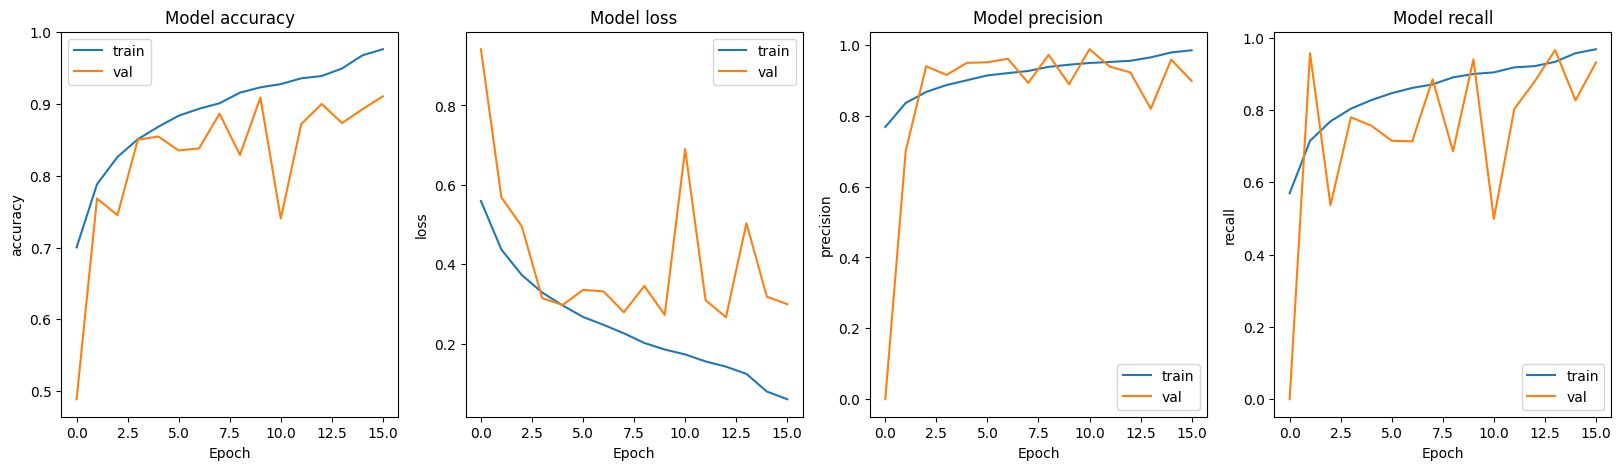

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss", "precision", "recall"]):
    ax[i].plot(base_history.history[metric])
    ax[i].plot(base_history.history["val_" + metric])
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Modell verwenden

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[-12.571544]]
This image is 100.00% bird and 0.00% dog.


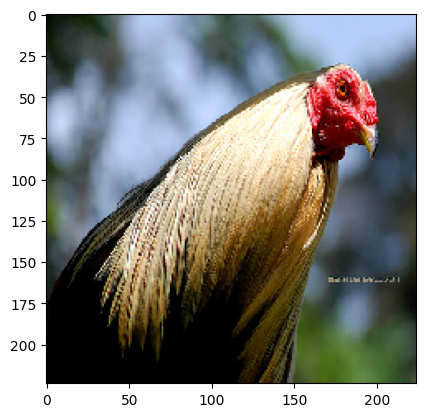

In [9]:
class_names = TRAIN_DS.class_names

img = keras.utils.load_img("data/dog_bird/images/bird/n01514668_3210.JPEG", target_size=IMAGE_SIZE)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # makes a batch out of the one image

predictions = model.predict(img_array)
if NUMBER_OF_CLASSES == 1:
    score = float(keras.ops.sigmoid(predictions[0][0]))
    print(f"This image is {100 * (1 - score):.2f}% {class_names[0]} and {100 * score:.2f}% {class_names[1]}.")
else:
    scores = keras.ops.softmax(predictions[0])
    for i, score in enumerate(scores):
        print(f"This image is {100 * score:.2f}% {class_names[i]}.")